In [0]:
'''
When to use transfer learning:
  1. not enough labelled data to train model from scratch
  2. you have effective pre-trained model already exists

When using transfer learning, we don't want to change the parameters in the feature extracting part, we only need to change the parameters in the classifier part(the weights in fully connected layers)
'''

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models#model is the package to import pretrained models
import numpy as np
import matplotlib.pyplot as plt

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (406/406), done.
remote: Total 408 (delta 2), reused 408 (delta 2), pack-reused 0
Receiving objects: 100% (408/408), 45.03 MiB | 39.51 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
!ls

ants_and_bees  sample_data


In [7]:
!ls ants_and_bees 

train  val


In [9]:
!ls ants_and_bees/train

ants  bees


In [0]:
!ls ants_and_bees/train/ants

In [31]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear =(-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

training_dataset = datasets.ImageFolder(root='ants_and_bees/train',transform=transform_train)
print(len(training_dataset))
testing_dataset = datasets.ImageFolder(root='ants_and_bees/val', transform=transform)
print(len(testing_dataset))

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size=20, shuffle=True)
testing_loader = torch.utils.data.DataLoader(dataset = testing_dataset, batch_size=20, shuffle=False)

244
153


In [0]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image*(0.5,0.5,0.5)+(0.5,0.5,0.5)
    return image

In [0]:
classes = ['ant','bee']

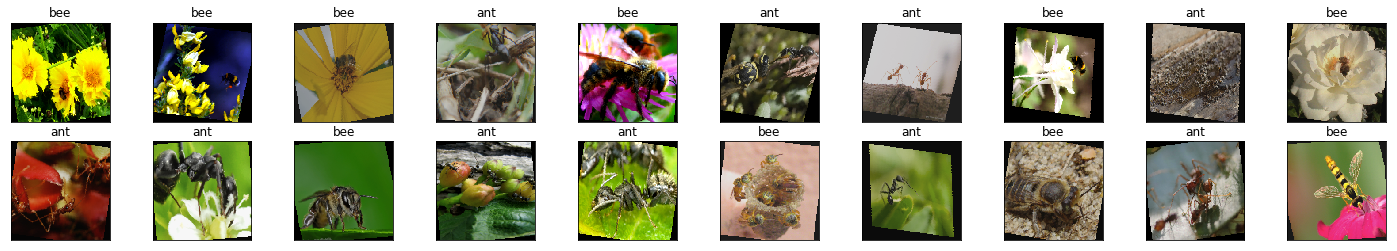

In [18]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in range(20):
    im = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    im.set_title(classes[labels[idx].item()])

In [46]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:13<00:00, 42298691.91it/s]


In [0]:
for params in model.features.parameters():
      params.requires_grad = False

In [48]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [49]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [51]:
epochs = 10
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for i in range(epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    counter =1
    #for loop 600 times, which is the number of batches, 
    #批量训练， 每次训练100张图片，不需要循环，一块input
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss +=loss.item()
        
        _, preds = torch.max(outputs, 1)
        epoch_acc += torch.sum(preds==labels.data)
    else:
        with torch.no_grad():
            for images, labels in testing_loader:
                images = images.to(device)
                labels = labels.to(device)
                val_outputs = model.forward(images)
                loss2 = criterion(val_outputs, labels)
                
                val_loss += loss2
                _, val_preds = torch.max(val_outputs, 1)
                val_acc += torch.sum(val_preds==labels.data)
                
        avg_epoch_loss = epoch_loss/len(training_loader.dataset)
        avg_epoch_acc = epoch_acc.float()/len(training_loader.dataset)
        print('epoch:',i, 'loss:{:.4f}'.format(avg_epoch_loss), 'accuracy:{:.4f}'.format(avg_epoch_acc))
        losses.append(avg_epoch_loss)
        accuracy.append(avg_epoch_acc)
        
        avg_val_loss = val_loss/len(testing_loader.dataset)
        avg_val_acc = val_acc.float()/len(testing_loader.dataset)
        print('epoch:',i, 'val_loss:{:.4f}'.format(avg_val_loss), 'val_accuracy:{:.4f}'.format(avg_val_acc))
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)

epoch: 0 loss:0.0277 accuracy:0.7377
epoch: 0 val_loss:0.0138 val_accuracy:0.8954
epoch: 1 loss:0.0176 accuracy:0.8156
epoch: 1 val_loss:0.0134 val_accuracy:0.9085
epoch: 2 loss:0.0138 accuracy:0.8566
epoch: 2 val_loss:0.0141 val_accuracy:0.9281
epoch: 3 loss:0.0126 accuracy:0.8770
epoch: 3 val_loss:0.0156 val_accuracy:0.9216
epoch: 4 loss:0.0149 accuracy:0.8648
epoch: 4 val_loss:0.0192 val_accuracy:0.9150
epoch: 5 loss:0.0089 accuracy:0.9344
epoch: 5 val_loss:0.0196 val_accuracy:0.9281
epoch: 6 loss:0.0101 accuracy:0.9344
epoch: 6 val_loss:0.0214 val_accuracy:0.9346
epoch: 7 loss:0.0111 accuracy:0.9098
epoch: 7 val_loss:0.0256 val_accuracy:0.9150
epoch: 8 loss:0.0102 accuracy:0.8934
epoch: 8 val_loss:0.0255 val_accuracy:0.9216
epoch: 9 loss:0.0144 accuracy:0.8648
epoch: 9 val_loss:0.0216 val_accuracy:0.9085


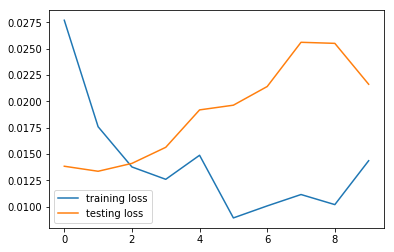

In [52]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='testing loss')
plt.legend()

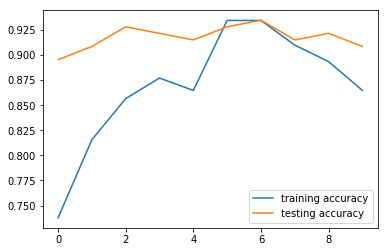

In [53]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracy, label='testing accuracy')
plt.legend()

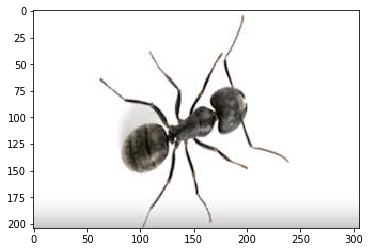

In [54]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://www.pestworld.org/media/561050/carpenter-ants.png?preset=pestCategoryVideo360'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

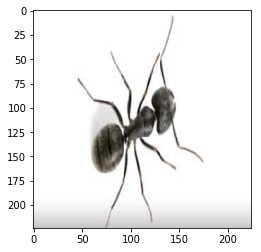

In [55]:
img=transform(img)
plt.imshow(im_convert(img))

In [56]:
img = img.to(device).unsqueeze(0)
output = model.forward(img)
number, pred = torch.max(output, 1)#the result tuple of two output tensors (max, max_indices), using only output can not give indices
#print(pred, number)
print(classes[pred.item()], number)

ant tensor([3.2082], grad_fn=<MaxBackward0>)


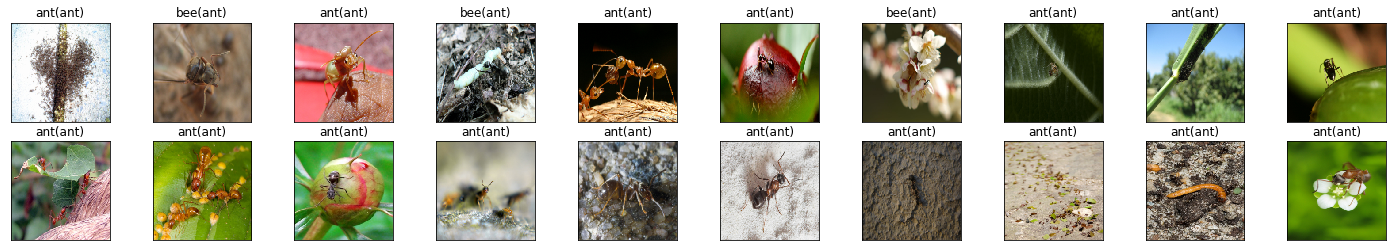

In [57]:
dataiter = iter(testing_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
_, preds = torch.max(output, 1)
                       
plt.figure(figsize=(25,4))

for idx in range(20):
  im = plt.subplot(2, 10, idx+1,xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  im.set_title('{}({})'.format(classes[preds[idx].item()], classes[labels[idx]]))